<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/AI_Driven_Stock_Price_Forecasting_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0504
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0030
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0019
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0021
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0017
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0015
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0013
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0011
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0011
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 9.5495e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1

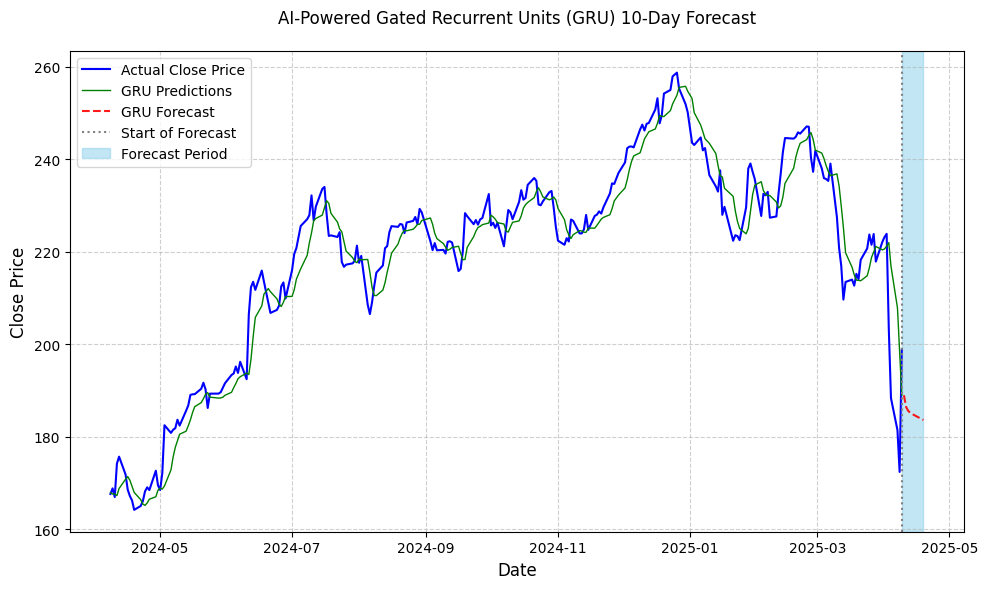

In [13]:

# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Download AAPL stock data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2025-04-10')

# Check for missing values
aapl_data.ffill(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_data['Close'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for model input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build GRU model
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# Make predictions
gr_predictions = gru_model.predict(X_test)
gr_predictions = scaler.inverse_transform(gr_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast future prices
def forecast_future(model, X_test, days=10):
    forecast_input = X_test[-1].reshape(1, seq_length, 1)
    forecast = []
    for _ in range(days):
        pred = model.predict(forecast_input)[0][0]
        forecast.append(pred)
        forecast_input = np.roll(forecast_input, -1, axis=1)
        forecast_input[0, -1, 0] = pred
    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

gr_forecast = forecast_future(gru_model, X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, gr_predictions)
r2 = r2_score(y_test_actual, gr_predictions)

# Create the evaluation metrics table for publication
evaluation_table = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'R-squared (R²)'],
    'Value': [f'{mse:.4f}', f'{r2:.4f}']
})

# Display the table in a format suitable for publication
print("\nEvaluation Metrics:")
print(evaluation_table.to_string(index=False))

# Visualization
date_index = aapl_data.index[-len(y_test):]
plt.figure(figsize=(10, 6))
plt.plot(date_index, y_test_actual, label='Actual Close Price', color='blue', linewidth=1.5)
plt.plot(date_index, gr_predictions, label='GRU Predictions', color='green', linestyle='-', linewidth=1)
forecast_dates = pd.date_range(start=date_index[-1], periods=11)[1:]
plt.plot(forecast_dates, gr_forecast, label='GRU Forecast', color='red', linestyle='--', linewidth=1.5, alpha=0.9)
plt.axvline(x=date_index[-1], color='gray', linestyle=':', linewidth=1.5, label='Start of Forecast')
plt.axvspan(date_index[-1], forecast_dates[-1], color='skyblue', alpha=0.5, label='Forecast Period')
plt.title("AI-Powered Gated Recurrent Units (GRU) 10-Day Forecast", fontsize=12, pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()
